### Building ChatBot with Multiple Tools Using LangGraph

#### AIm
- Create a ChatBot with Tool Capabilities From arxiv,wikipedia search and some functions

In [2]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper

In [ ]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)
# print(arxiv.run("What are the latest research papers on deep learning?"))

arxiv


In [7]:
arxiv.invoke("What are the latest research papers on deep learning?")


'Published: 2023-01-03\nTitle: Deep Learning and Computational Physics (Lecture Notes)\nAuthors: Deep Ray, Orazio Pinti, Assad A. Oberai\nSummary: These notes were compiled as lecture notes for a course developed and taught at the University of the Southern California. They should be accessible to a typical engineering graduate student with a strong background in Applied Mathematics.\n  The main objective of these notes is to introduce a student who is familiar with concepts in linear algebra and par'

In [15]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wikipedia = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wikipedia.name)
print(wikipedia.run("Who is Quentin tarantino"))

wikipedia
Page: Quentin Tarantino filmography
Summary: Quentin Tarantino is an American filmmaker, actor and author who has made ten films. He first began his career in the 1980s by directing and writing Love Birds In Bondage and writing, directing and starring in the black-and-white My Best Friend's Birthday, an amateur short film which was never officially released. He impersonated musician Elvis Presley in a small role in the sitcom The Golden Girls (1988), and briefly appeared in Eddie Presley (1992).


In [14]:
wikipedia.invoke("Who is Quentin tarantino")

"Page: Quentin Tarantino filmography\nSummary: Quentin Tarantino is an American filmmaker, actor and author who has made ten films. He first began his career in the 1980s by directing and writing Love Birds In Bondage and writing, directing and starring in the black-and-white My Best Friend's Birthday, an amateur short film which was never officially released. He impersonated musician Elvis Presley in a small role in the sitcom The Golden Girls (1988), and briefly appeared in Eddie Presley (1992)."

In [17]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [20]:
# Import the TavilySearchResults tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_search = TavilySearchResults()


In [22]:
tavily_search.invoke("What are the latest news on AI?")

[{'title': 'AI News | Latest News | Insights Powering AI-Driven Business Growth',
  'url': 'https://www.artificialintelligence-news.com/',
  'content': "# How to Calculate Business Value and Cost for Generative AI Use Cases\n\n# Gartner Data & Analytics Summit unveils expanded AI agenda for 2026\n\n#### Applications\n\n### Thailand becomes one of the first in Asia to get the Sora app\n\nEntertainment & Media\n\nOctober 30, 2025\n\n### Malaysia launches Ryt Bank, its first AI-powered bank\n\nFinance AI\n\nAugust 26, 2025\n\n### Google’s Veo 3 AI video creation tools are now widely available\n\nAI in Action\n\nJuly 29, 2025\n\n#### Computer Vision\n\n### US and Japan announce sweeping AI and tech collaboration\n\nArtificial Intelligence\n\nApril 11, 2024\n\n### UK and Canada sign AI compute agreement\n\nArtificial Intelligence\n\nJanuary 31, 2024\n\n### Quantum AI represents a ‘transformative advancement’\n\nAI Hardware & Chips\n\nNovember 14, 2023\n\n#### Machine Learning [...] Open-Sou

In [23]:
### Combine tools in a chatbot in the list

tools = [arxiv,wikipedia,tavily_search]

In [ ]:
### intialize the llm with the tools

from langchain_groq import ChatGroq


llm = ChatGroq(model="llama-3.1-8b-instant")

llm_with_tools = llm.bind_tools(tools)  ## We have to bind the tools to the llm to use them in the chatbot

In [31]:
from langchain_core.messages import HumanMessage,AIMessage

llm_with_tools.invoke([HumanMessage(content="Who is Quentin Tarantino and what are the latest news on his upcoming projects?")])


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'bmyxd1mzp', 'function': {'arguments': '{"query":"Quentin Tarantino"}', 'name': 'wikipedia'}, 'type': 'function'}, {'id': 'e9a67vxfb', 'function': {'arguments': '{"query":"Quentin Tarantino latest projects news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 563, 'total_tokens': 603, 'completion_time': 0.060693865, 'completion_tokens_details': None, 'prompt_time': 0.044946047, 'prompt_tokens_details': None, 'queue_time': 0.091124244, 'total_time': 0.105639912}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c771e-8b48-7b82-8070-8b11aaa0c14f-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Quentin Tarantino'}, 'id': 'bmyxd1mzp', 'type': 'tool_call'}, {'name': 'tavily_search_re

In [42]:
llm_with_tools.invoke([HumanMessage(content="Who is Quentin Tarantino and what are the latest news on his upcoming projects?")]).tool_calls

[{'name': 'wikipedia',
  'args': {'query': 'Quentin Tarantino'},
  'id': 'jp6x4hmqs',
  'type': 'tool_call'},
 {'name': 'wikipedia',
  'args': {'query': 'Quentin Tarantino latest news'},
  'id': '1yweyhysh',
  'type': 'tool_call'},
 {'name': 'tavily_search_results_json',
  'args': {'query': 'Quentin Tarantino latest projects'},
  'id': '65skgf7n5',
  'type': 'tool_call'}]

### Upto now we have done the brief demo on multiple tools and their usage and  now we will create the chatbot using multiple tools integration


In [43]:
### State Schema

from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages()]

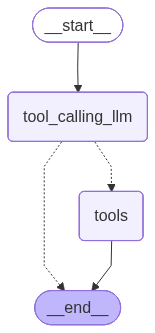

In [48]:
### Entire Chatrobot response with tool calls and final response

# Create a StateGraph to use the LangGraph

from langgraph.graph import StateGraph,START,END
from IPython.display import Image, display

from langgraph.prebuilt import ToolNode,tools_condition


### Node Defintions

def tool_calling_llm(state:State):
    return {"messages": llm_with_tools.invoke(state["messages"])}


builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))



### Flow of the graph
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",
# If there are tool calls, go to the tools node, else end the graph
# The tools_condition checks if there are tool calls in the response from the llm
   tools_condition)
builder.add_edge("tools",END)


graph_builder=builder.compile()

display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [49]:
messages = graph_builder.invoke({"messages": [HumanMessage(content="1706.03762")]})


for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (qkcbcttzm)
 Call ID: qkcbcttzm
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, base
